In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'
import seaborn as sns
import sys
sys.path.append('..')
from glob import glob
import eeg_decoder

from rsa_utils import crossnobis

from collections import defaultdict

from os import path

from sklearn.linear_model import LinearRegression

import pickle

from scipy.stats import wilcoxon

from statsmodels.stats.multitest import multipletests

from scipy.stats import rankdata
%load_ext autoreload
%autoreload 2

In [2]:
OVERWRITE = False  # recomputing RDMs, which takes ~1-2mins per participant

# theoretical RDMS
## we do this first so we can get some info from the coherence RDM

In [3]:
from matplotlib.colors import LinearSegmentedColormap

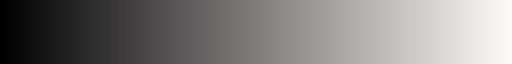

In [4]:
cmap = LinearSegmentedColormap.from_list('mycmap', ['black', 'snow'])
cmap

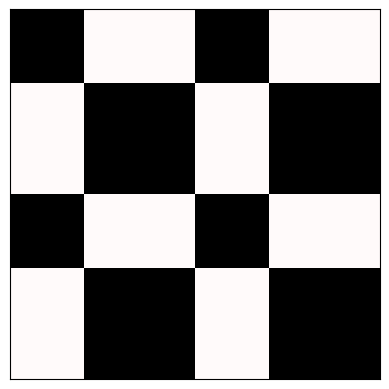

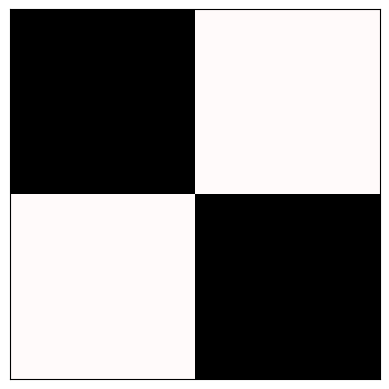

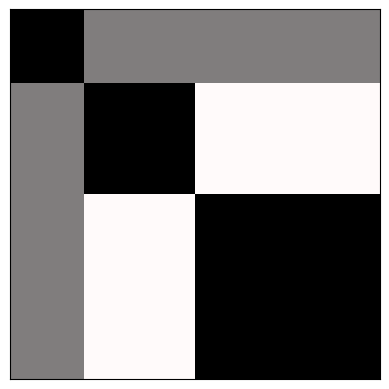

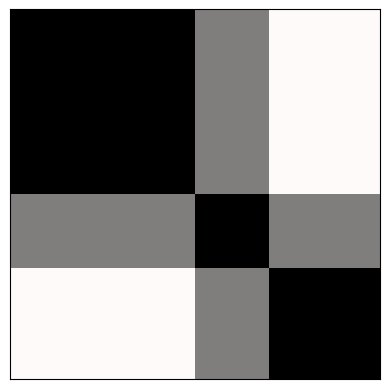

In [5]:
factors = ['Cont. Indep. Load', 'AttendedFeature','ColorLoad','MotionLoad']

condition_details = {
    # NOTE: change the values to effect the relative distance between the conditions.
    # We tested making the content load signals steps from 1-2 smaller or larger than 0-1, but it didn't change the results.
    'C1_0':{'Cont. Indep. Load':1, 'AttendedFeature':0, 'ColorLoad':1,'MotionLoad':0},
    'C1_1':{'Cont. Indep. Load':1, 'AttendedFeature':0, 'ColorLoad':1,'MotionLoad':0},
    'C2_0':{'Cont. Indep. Load':2, 'AttendedFeature':0, 'ColorLoad':2,'MotionLoad':0},
    'C2_5':{'Cont. Indep. Load':2, 'AttendedFeature':0, 'ColorLoad':2,'MotionLoad':0},
    'C2_1':{'Cont. Indep. Load':2, 'AttendedFeature':0, 'ColorLoad':2,'MotionLoad':0},
    'M1_0':{'Cont. Indep. Load':1, 'AttendedFeature':1, 'ColorLoad':0,'MotionLoad':1},
    'M1_1':{'Cont. Indep. Load':1, 'AttendedFeature':1, 'ColorLoad':0,'MotionLoad':1},
    'M2_0':{'Cont. Indep. Load':2, 'AttendedFeature':1, 'ColorLoad':0,'MotionLoad':2},
    'M2_5':{'Cont. Indep. Load':2, 'AttendedFeature':1, 'ColorLoad':0,'MotionLoad':2},
    'M2_1':{'Cont. Indep. Load':2, 'AttendedFeature':1, 'ColorLoad':0,'MotionLoad':2}
}
labels=list(condition_details.keys())
conditions=labels
RDMs = defaultdict(lambda:np.zeros((len(conditions), len(conditions))))

for factor in factors:
    for i, condi in enumerate(condition_details):
        for j, condj in enumerate(condition_details):
            RDMs[factor][i, j] = np.abs(condition_details[condi][factor] - condition_details[condj][factor])

for factor in factors:
    ax = sns.heatmap(RDMs[factor], xticklabels=[], yticklabels=[], square=True, cmap=cmap, cbar=False) # linewidths=.01, linecolor='black')
    for _, spine in ax.spines.items():
        spine.set_visible(True)
    plt.savefig(f'figures/RDM_{factor}.svg')
    plt.show()
    plt.close()

## Coherence

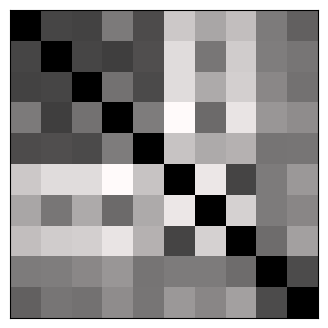

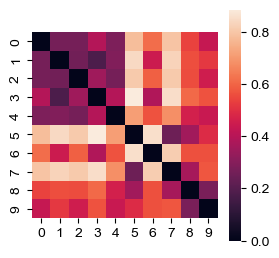

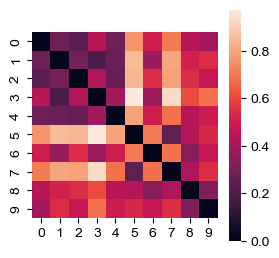

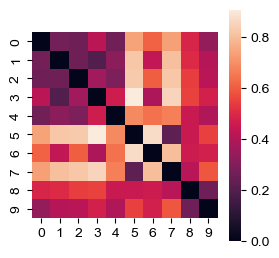

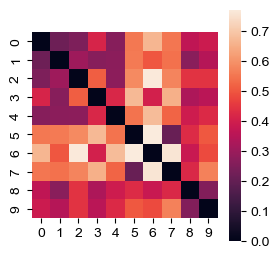

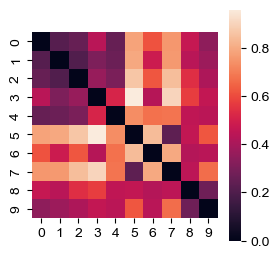

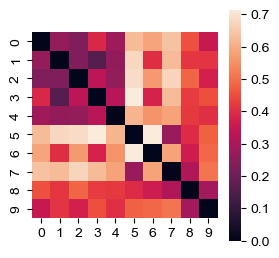

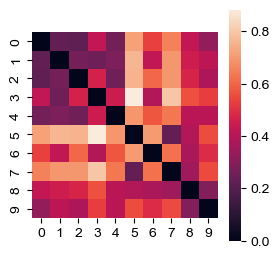

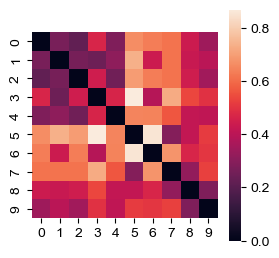

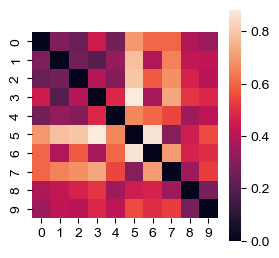

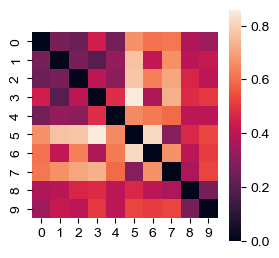

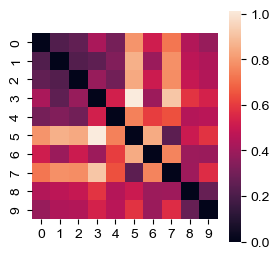

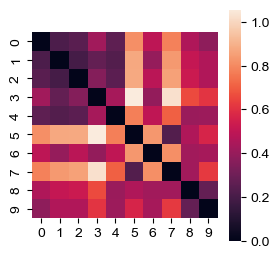

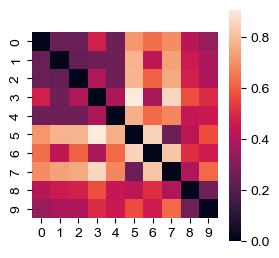

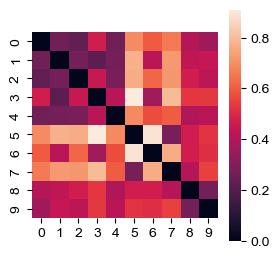

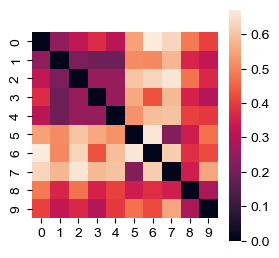

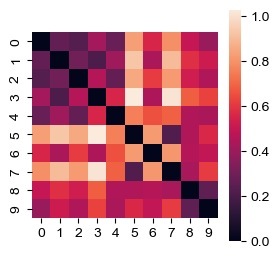

In [75]:
interp_coh = eeg_decoder.Interpreter()
interp_coh.load_results('coherence_axis')
coh_scores = interp_coh.confidence_scores.mean(2) #[..., coh_order]  # mean across iterations
# coh_scores = coh_scores[:, 30:, :].mean(1)  # mean across delay period

#average RDM, for plotting
coh_rdm = np.abs(coh_scores.mean(0)[:, :, np.newaxis] - coh_scores.mean(0)[:, np.newaxis, :])
plt.figure(figsize=(4, 4))
# sns.heatmap(coh_rdm[interp_coh.t > 500, :, :].mean(0), square=True)
ax = sns.heatmap(coh_rdm[interp_coh.t > 500, :, :].mean(0), xticklabels=[], yticklabels=[], square=True, cmap=cmap, cbar=False) # linewidths=.01, linecolor='black')
for _, spine in ax.spines.items():
    spine.set_visible(True)
plt.savefig(f'output/figures/RDM_Coherence.svg')
plt.show()
plt.close()

coh_rdms = {}
for isub in range(coh_scores.shape[0]):
    curr_scores = np.delete(coh_scores, isub, 0)
    curr_scores = curr_scores.mean(0)
    coh_rdms[isub] = np.abs(curr_scores[:, :, np.newaxis] - curr_scores[:, np.newaxis, :])
    plt.figure(figsize=(3, 3))
    sns.heatmap(coh_rdms[isub][interp_coh.t > 500, :, :].mean(0), square=True)
    plt.show()
    plt.close()

# Compute subject RDMs

In [7]:
np.random.seed(42)

time_window = 25 
time_step = 25
n_splits = 10_000

experiment_name = 'data'
data_dir = f'./data/'
exp = eeg_decoder.Experiment(experiment_name,data_dir,trim_timepoints=[-200,1500])

cond_order = [110,111,120,121,122,210,211,220,221,222]

# Compute EEG-based RDMs

In [8]:
def str_to_arr(s, sep=' '):
    pieces = s.replace('[', '').replace(']', '').replace(',', '').split(sep)
    return np.array([float(i) for i in pieces])

def get_target_coherences(row):
    return int(np.sum(str_to_arr(row['Coherences'])[:row['SetSize']]))

def get_distractor_coherences(row):
    return int(np.sum(str_to_arr(row['Coherences'])[row['SetSize']:]))

def add_condition_info(beh):
    beh['cond_labels'] = beh['BlockFeature']*100+100  # color = 100, motion = 200
    beh['cond_labels'] += beh['SetSize']*10  # ss1=10, ss2=20
    beh['cond_labels'] += beh.apply(get_target_coherences, axis=1)*1  # coherence = 0, 1, 2

    # add info about the distractor coherence, shown below to be uninformative generally
    beh['full_cond_labels'] =  beh['cond_labels'].values*10 # shift by 1 decimal place
    beh['full_cond_labels'] += beh.apply(get_distractor_coherences, axis=1)  # distractor coherence = 0, 1, 2

    return beh

In [9]:
if OVERWRITE:
    cond_accs = {}
    for isub in range(exp.nsub):
        sub_file_out = f'output/rdms/sub_{isub}.npy'
        print(f'Computing RDMs for sub {isub}...')

        xdata,_ = exp.load_eeg(isub)
        beh = pd.DataFrame(exp.load_behavior(isub))
        beh = add_condition_info(beh)

        # filter out set size 0 trials
        beh =  beh.query('SetSize != 0')
        idx = beh.index
        xdata = xdata[idx]
        beh = beh.reset_index(drop=True)

        ydata = beh['cond_labels'].values
        
        # get condition level accuracy to add as a nuisance regressor
        cond_accs[isub] = beh.groupby('cond_labels').mean().loc[cond_order, 'ACC']

        # compress xdata to same time windows as decoding
        xdata_binned = np.full((xdata.shape[0], xdata.shape[1], len(interp_coh.t)), np.nan)
        for i, bin_start in enumerate(interp_coh.t):
            if i < len(interp_coh.t)-1:
                window_idx = (exp.info['times'] >= bin_start) & (exp.info['times'] < interp_coh.t[i+1])
            else:
                window_idx = (exp.info['times'] >= bin_start)
            xdata_binned[:, :, i] = xdata[:, :, window_idx].mean(2)

        sub_rdms = crossnobis(xdata_binned, ydata, cond_order, n_splits=n_splits)
        np.save(sub_file_out, sub_rdms)

    with open('output/beh_accs.pkl', 'wb') as f:
        pickle.dump(cond_accs, f)

with open('output/beh_accs.pkl', 'rb') as f:
    cond_accs = pickle.load(f)

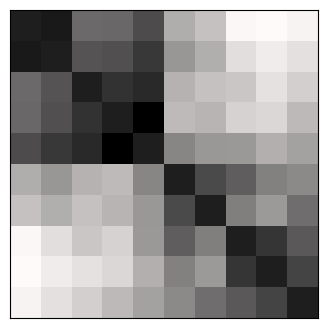

In [10]:
avg_RDM = np.zeros((len(conditions), len(conditions)))
for isub in range(exp.nsub):
    sub_file = f'output/rdms/sub_{isub}.npy'
    sub_rdms = np.load(sub_file)
    avg_RDM += sub_rdms[:,:,interp_coh.t > 500].mean(2)  # average across the delay period

avg_RDM /= exp.nsub
plt.figure(figsize=(4, 4))
ax = sns.heatmap(avg_RDM, xticklabels=[], yticklabels=[], square=True, cmap=cmap, cbar=False) # linewidths=.01, linecolor='black')
for _, spine in ax.spines.items():
    spine.set_visible(True)
plt.savefig(f'output/figures/RDM_empirical.svg')
plt.show()
plt.close()
    

# Accuracy, pupil-size, and interaction RDMs

In [12]:
import scipy.stats as sista

ridx, cidx = np.triu_indices(len(cond_order), k=1)

bad_eye_subs = [14]

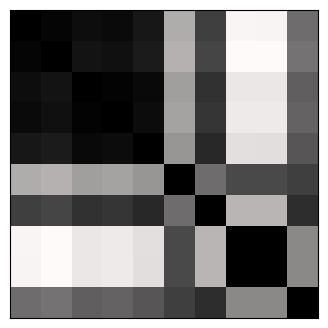

In [214]:
full_acc = pd.DataFrame()
for isub in cond_accs:
    full_acc = pd.concat([full_acc, pd.DataFrame(cond_accs[isub])], axis=0)

full_acc = full_acc.groupby('cond_labels').mean().loc[cond_order].reset_index()

group_avg_acc_RDM = np.zeros((len(conditions), len(conditions)))
group_avg_acc_RDM[ridx, cidx] = np.abs(full_acc.loc[ridx, 'ACC'].values - full_acc.loc[cidx, 'ACC'].values)
group_avg_acc_RDM = group_avg_acc_RDM + group_avg_acc_RDM.T
plt.figure(figsize=(4, 4))
ax = sns.heatmap(group_avg_acc_RDM, xticklabels=[], yticklabels=[], square=True, cmap=cmap, cbar=False) # linewidths=.01, linecolor='black')
for _, spine in ax.spines.items():
        spine.set_visible(True)
plt.savefig(f'output/figures/RDM_condition_ACC_groupAvg.svg')
plt.show()
plt.close()

full_acc['acc_z'] = sista.zscore(full_acc['ACC'], ddof=1)

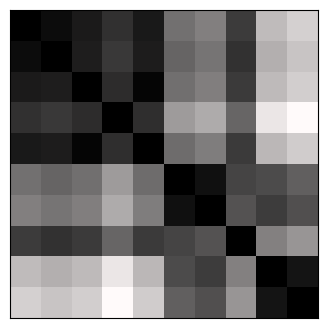

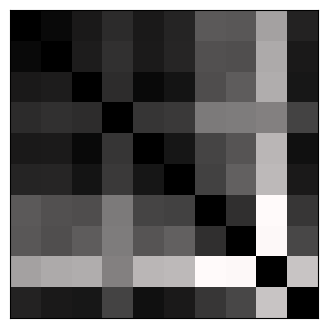

In [215]:
pupil_by_time = pd.read_csv('output/pupil_by_time.csv')
pupil_by_time = pupil_by_time.groupby(['Cond', 'Time']).mean().loc[:, 'Pupil'].unstack()
pupil_by_time = pupil_by_time.loc[cond_order]  # making sure the order is correct (and potentially drop SS0 conditions, if they hadn't already been dropped)

pupil_by_time_z = (pupil_by_time - pupil_by_time.mean(0)) / pupil_by_time.std(axis=0, ddof=1) # z-score each column, to enable interactions with accuracy


pupil_by_time_RDMs = []
interaction_by_time_RDMs = []
for t in range(len(pupil_by_time_z.columns)):
    curr_pupil_RDM = np.zeros((len(cond_order), len(cond_order)))
    curr_interaction_RDM = np.zeros((len(cond_order), len(cond_order)))

    curr_pupil_vals = pupil_by_time_z.iloc[:, t].values

    curr_pupil_RDM[ridx, cidx] = np.abs(curr_pupil_vals[ridx] - curr_pupil_vals[cidx])
    curr_pupil_RDM += curr_pupil_RDM.T
    pupil_by_time_RDMs.append(curr_pupil_RDM)


    curr_interaction_vals = full_acc['acc_z'].values * curr_pupil_vals

    curr_interaction_RDM[ridx, cidx] = np.abs(curr_interaction_vals[ridx] - curr_interaction_vals[cidx])
    curr_interaction_RDM += curr_interaction_RDM.T
    interaction_by_time_RDMs.append(curr_interaction_RDM)



plt.figure(figsize=(4, 4))
ax = sns.heatmap(np.stack(pupil_by_time_RDMs, 0)[interp_coh.t > 500].mean(0), xticklabels=[], yticklabels=[], square=True, cmap=cmap, cbar=False) # linewidths=.01, linecolor='black')
for _, spine in ax.spines.items():
        spine.set_visible(True)
plt.savefig(f'output/figures/RDM_condition_Pupil_groupAvg.svg')
plt.show()
plt.close()

plt.figure(figsize=(4, 4))
ax = sns.heatmap(np.stack(interaction_by_time_RDMs, 0)[interp_coh.t > 500].mean(0), xticklabels=[], yticklabels=[], square=True, cmap=cmap, cbar=False) # linewidths=.01, linecolor='black')
for _, spine in ax.spines.items():
        spine.set_visible(True)
plt.savefig(f'output/figures/RDM_condition_Interaction_groupAvg.svg')
plt.show()
plt.close()

In [140]:
# repeat above, running per subject
pupil_by_time = pd.read_csv('output/pupil_by_time.csv')

pupil_by_time_RDMs_per_sub = defaultdict(list)
interaction_by_time_RDMs_per_sub = defaultdict(list)

for isub in cond_accs:
    if isub in bad_eye_subs:
        pass
    else:
        sub_acc = pd.DataFrame(cond_accs[isub])
        sub_pupil = pupil_by_time.query(f'sub == {isub}').groupby(['Cond', 'Time']).mean().loc[:, 'Pupil'].unstack()

        sub_pupil = sub_pupil.loc[cond_order]  # making sure the order is correct (and potentially drop SS0 conditions, if they hadn't already been dropped)

        sub_pupil_z = (sub_pupil - sub_pupil.mean(0)) / sub_pupil.std(axis=0, ddof=1) # z-score each column, to enable interactions with accuracy

        # for the interaction
        sub_acc['acc_z'] = sista.zscore(sub_acc['ACC'], ddof=1)

        for t in range(len(pupil_by_time_z.columns)):
            curr_pupil_RDM = np.zeros((len(cond_order), len(cond_order)))
            curr_interaction_RDM = np.zeros((len(cond_order), len(cond_order)))

            curr_pupil_vals = sub_pupil_z.iloc[:, t].values

            curr_pupil_RDM[ridx, cidx] = np.abs(curr_pupil_vals[ridx] - curr_pupil_vals[cidx])
            curr_pupil_RDM += curr_pupil_RDM.T
            pupil_by_time_RDMs_per_sub[isub].append(curr_pupil_RDM)


            curr_interaction_vals = sub_acc['acc_z'].values * curr_pupil_vals

            curr_interaction_RDM[ridx, cidx] = np.abs(curr_interaction_vals[ridx] - curr_interaction_vals[cidx])
            curr_interaction_RDM += curr_interaction_RDM.T
            interaction_by_time_RDMs_per_sub[isub].append(curr_interaction_RDM)
        

# Coarse coding of Accuracy

In [141]:
cond_acc_details = {
    'C1_0':{'BlockFeature':'Color', 'SetSize':1},
    'C1_1':{'BlockFeature':'Color', 'SetSize':1},
    'C2_0':{'BlockFeature':'Color', 'SetSize':2},
    'C2_1':{'BlockFeature':'Color', 'SetSize':2},
    'C2_5':{'BlockFeature':'Color', 'SetSize':2},
    'M1_0':{'BlockFeature':'Motion', 'SetSize':1},
    'M1_1':{'BlockFeature':'Motion', 'SetSize':1},
    'M2_0':{'BlockFeature':'Motion', 'SetSize':2},
    'M2_5':{'BlockFeature':'Motion', 'SetSize':2},
    'M2_1':{'BlockFeature':'Motion', 'SetSize':2}
}

In [142]:
all_accs = pd.read_csv('output/subject_accs.csv')
all_accs

,Subject,SetSize,BlockFeature,ACC
0,0,1,Color,1.000000
1,0,1,Motion,0.938053
2,0,2,Color,0.981481
3,0,2,Motion,0.662037
4,1,1,Color,1.000000
...,...,...,...,...
59,14,2,Motion,0.839744
60,15,1,Color,0.987500
61,15,1,Motion,0.770213
62,15,2,Color,0.975709


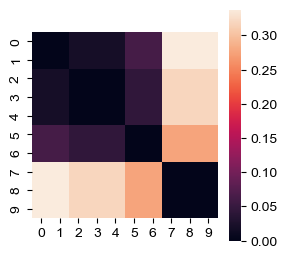

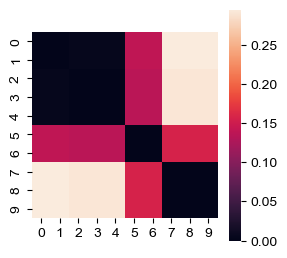

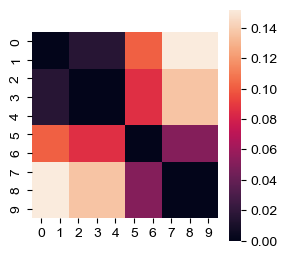

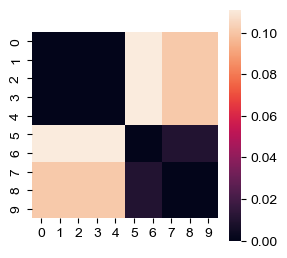

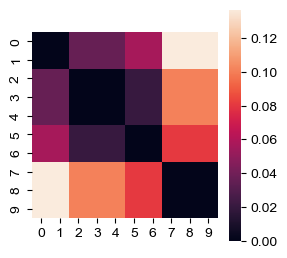

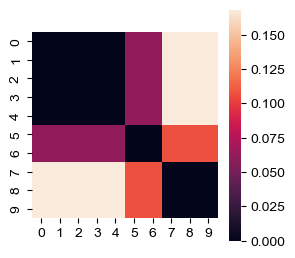

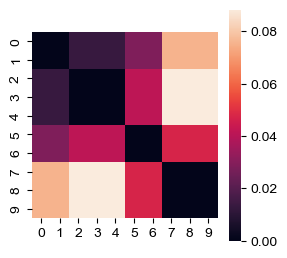

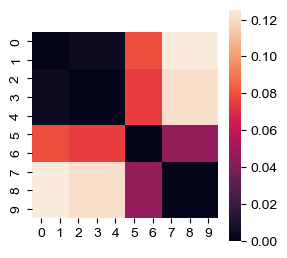

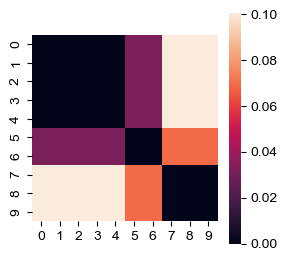

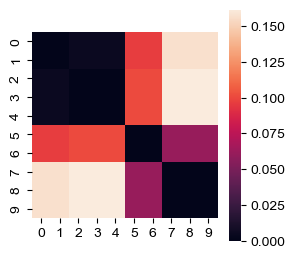

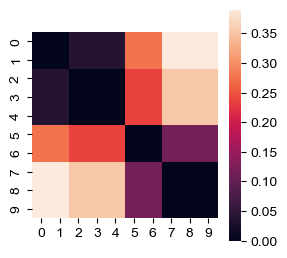

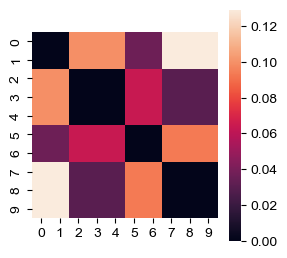

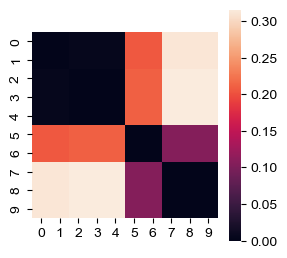

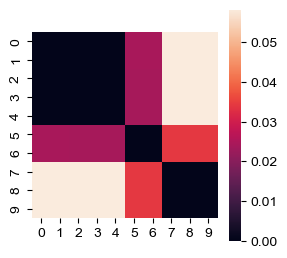

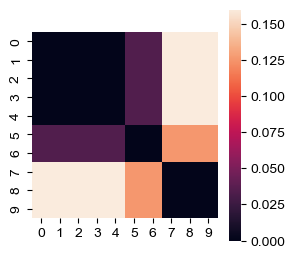

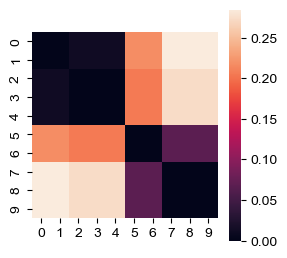

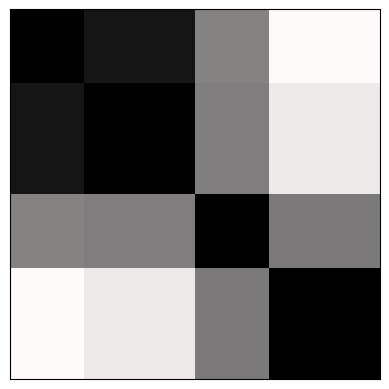

In [143]:
coarse_acc_RDMs = defaultdict(lambda:np.zeros((len(conditions), len(conditions))))
for isub in range(exp.nsub):
    sub_accs = all_accs.query(f"Subject=={isub}")
    for i, condi in enumerate(cond_acc_details):
        condi_feat = cond_acc_details[condi]['BlockFeature']
        condi_ss = cond_acc_details[condi]['SetSize']

        condi_acc = sub_accs.query(f"BlockFeature=='{condi_feat}' & SetSize=={condi_ss}").ACC.values[0]

        for j, condj in enumerate(condition_details):

            condj_feat = cond_acc_details[condj]['BlockFeature']
            condj_ss = cond_acc_details[condj]['SetSize']

            condj_acc = sub_accs.query(f"BlockFeature=='{condj_feat}' & SetSize=={condj_ss}").ACC.values[0]

            coarse_acc_RDMs[isub][i, j] = np.abs(condi_acc - condj_acc)


    plt.figure(figsize=(3, 3))
    sns.heatmap(coarse_acc_RDMs[isub], square=True)
    plt.show()
    plt.close()

avg_rdm = np.zeros((len(conditions), len(conditions)))
for isub in range(exp.nsub):
    avg_rdm += coarse_acc_RDMs[isub]
avg_rdm /= exp.nsub

ax = sns.heatmap(avg_rdm, xticklabels=[], yticklabels=[], square=True, cmap=cmap, cbar=False) # linewidths=.01, linecolor='black')
for _, spine in ax.spines.items():
    spine.set_visible(True)
plt.savefig(f'output/figures/RDM_coarse_ACC.svg')
plt.show()
plt.close()

# Semipartial Correlations

In [144]:
# get upper triangle indices
ridx, cidx = np.triu_indices(len(condition_details), k=1)

RDM_df = pd.DataFrame()
for factor, RDM in RDMs.items():
    RDM_df[factor] = RDM[ridx, cidx]
# this isn't the best practice because it's the intercept, not the total, but it makes renaming the columns easier in a results df
RDM_df['Total'] = 1  
RDM_df.head()

,Cont. Indep. Load,AttendedFeature,ColorLoad,MotionLoad,Total
0,0.0,0.0,0.0,0.0,1
1,1.0,0.0,1.0,0.0,1
2,1.0,0.0,1.0,0.0,1
3,1.0,0.0,1.0,0.0,1
4,0.0,1.0,1.0,1.0,1


In [229]:
for isub in range(exp.nsub):
    sub_file = f'output/rdms/sub_{isub}.npy'
    sub_RDMs = np.load(sub_file)

timepoints = interp_coh.t + 12.5

color_palette = {
 'Cont. Indep. Load': 'tab:red',
 'AttendedFeature': 'tab:blue',
 'ColorLoad': 'darkorange', 
 'MotionLoad': 'tab:green',
 'Coherence': 'tab:cyan',
 'Accuracy': 'tab:pink',
 'Pupil': 'gold',
 'Accuracy*Pupil': 'tab:brown', #'mediumvioletred',
 'Orientation': 'tab:purple'  # not included in this analysis, but listed for completeness and consistency with other plots
 }

In [230]:
def get_semipartial_correlations(RDM_df, sub_RDMs, factors=None, other_RDMs = None, skip_subs=None):
    if factors is None:
        factors = ['Cont. Indep. Load', 'AttendedFeature', 'ColorLoad', 'MotionLoad']
    # basecols = factors + ['Total']

    skip_subs = skip_subs if skip_subs is not None else []

    partial_r_df = pd.DataFrame()
    for isub in range(exp.nsub):
        if isub in skip_subs:
            continue
        sub_file = f'output/rdms/sub_{isub}.npy'
        sub_RDMs = np.load(sub_file)
        ranked_dists = rankdata(sub_RDMs[ridx, cidx, :], axis=0) 

        r_scores = defaultdict(lambda : np.zeros((ranked_dists.shape[1])))
        for t in range(ranked_dists.shape[1]):
            curr_dists = ranked_dists[:, t]

            RDM_df = RDM_df.loc[:, factors]  # drop previous additional columns, if any, and make sure intercept is last
            
            if other_RDMs is not None:
                for fac in other_RDMs:
                    curr_RDMs = other_RDMs[fac]
                    if type(curr_RDMs) in [dict, defaultdict]:  # assume there is an RDM per subject
                        sub_RDM = curr_RDMs[isub]
                        if type(sub_RDM) == list:  # assume there is an RDM per timepoint
                            RDM_df[fac] = sub_RDM[t][ridx, cidx]
                        elif sub_RDM.ndim == 3:  # time dimension built into the RDM
                            RDM_df[fac] = sub_RDM[t][ridx, cidx]
                        else:
                            RDM_df[fac] = sub_RDM[ridx, cidx]
                    else:
                        if type(curr_RDMs)==list:  # assume there is an RDM per timepoint, but shared across subjects
                            RDM_df[fac] = curr_RDMs[t][ridx, cidx]
                        elif curr_RDMs.ndim == 3:
                            RDM_df[fac] = curr_RDMs[t][ridx, cidx]
                        else:
                            RDM_df[fac] = curr_RDMs[ridx, cidx]  # just assume there is a single RDM for all timepoints and subjects (e.g., group averaged accuracy)
            ranked_df = RDM_df.rank(axis=0)
            ranked_df['int'] = 1
            ranked_vals = ranked_df.values

            fitted_lm = LinearRegression().fit(ranked_vals, curr_dists)
            full_r2 = fitted_lm.score(ranked_vals, curr_dists)

            # get partial r for each factor
            for col in range(ranked_vals.shape[1]-1): # skip intercept column
                submodel_r2 = LinearRegression().fit(np.delete(ranked_vals, col, axis=1), curr_dists).score(np.delete(ranked_vals, col, axis=1), curr_dists)
                r_scores[col][t] = np.sqrt(full_r2 - submodel_r2) * np.sign(fitted_lm.coef_[col])


        # make into a dataframe
        r_df = pd.DataFrame(r_scores)
        r_df.columns = RDM_df.columns
        r_df['sid'] = isub
        r_df['timepoint'] = timepoints
        sub_df = pd.melt(r_df, id_vars=['sid', 'timepoint'], value_vars=r_df.columns[:-2], var_name='factor', value_name='semipartial correlation')

        partial_r_df = pd.concat([partial_r_df, sub_df], axis=0)

    partial_r_df = partial_r_df.reset_index(drop=True)
    partial_r_df = partial_r_df.query("factor != 'Total'")  # drop the intercept column results

    return partial_r_df

In [250]:
def plot_and_test_corrs(partial_r_df, alternative='greater', title=None, color_palette=color_palette, factors=None):
    plt.figure(figsize=(12, 7))
    
    plt.plot(timepoints, np.zeros(len(timepoints)), color='black', linestyle='--')

    factors = list(partial_r_df['factor'].unique()) if factors is None else factors
    prdf = partial_r_df.query('factor == @factors')
    prdf.loc[:,'factor'] = pd.Categorical(prdf.factor.values, categories=list(reversed(factors)), ordered=True)  # make the columns ordered, but reverse ordered so most important are plotted on top
    
    ax = sns.lineplot(data=prdf.sort_values('factor'), x='timepoint', y='semipartial correlation', hue='factor', errorbar=None, linewidth=1, palette=color_palette, alpha=.5)

    min_val = np.round(prdf.groupby(['factor', 'timepoint']).mean()['semipartial correlation'].min(), 2)
    
    for i,factor in enumerate(factors):

        if factor=='Total':
            continue

        p_vals = []
        for t in partial_r_df['timepoint'].unique():
            x = partial_r_df.query(f"timepoint=={t} and factor=='{factor}'")['semipartial correlation'].values
            _,p = wilcoxon(x=x, alternative=alternative)
            p_vals.append(p)

        _, corrected_p, _, _ = multipletests(p_vals, method='fdr_bh')
        sig05 = corrected_p < .05
        
        plt.scatter(timepoints[sig05], np.ones(sum(sig05))*(min_val-.025*i),
                                marker='s', s=15, color=color_palette[factor], label=None)
        sig_timepoints = timepoints[sig05]
        print(f'{factor} Significant timepoints: {sig_timepoints}')

        # plot opaque lines for bins that were significant
        for t in np.where(sig05)[0]:
            timepoint = timepoints[t]
            curr_mean = partial_r_df.query(f"timepoint=={timepoint} and factor=='{factor}'")['semipartial correlation'].values.mean()

            # fill in the time bin arround the current timepoint

            # left half
            if t==0:
                pass
            else:
                t_left = t-1
                prev_timepoint = timepoints[t_left]
                timepoint_left = timepoint - 12.5  # edge of the window

                prev_mean = partial_r_df.query(f"timepoint=={prev_timepoint} and factor=='{factor}'")['semipartial correlation'].values.mean()
                mean_betwen_times = np.mean([curr_mean, prev_mean])  # get halfway to the next value
                sns.lineplot(x=[timepoint_left, timepoint], y=[mean_betwen_times, curr_mean], color=color_palette[factor], alpha=1, linewidth=3, label=None)

            # right half

            if t == len(sig05)-1:
                pass
            else:
                t_right = t+1
                next_timepoint = timepoints[t_right]
                timepoint_right = timepoint + 12.5 # edge of window

                next_mean = partial_r_df.query(f"timepoint=={next_timepoint} and factor=='{factor}'")['semipartial correlation'].values.mean()
                mean_betwen_times = np.mean([curr_mean, next_mean])
                sns.lineplot(x=[timepoint, timepoint_right], y=[curr_mean, mean_betwen_times], color=color_palette[factor], alpha=1, linewidth=3, label=None)

    handles, labels = ax.get_legend_handles_labels()
    # move legend to outside of figure
    ax.legend(handles[::-1], labels[::-1], title='Factor', bbox_to_anchor=(1, 1.05), fontsize=12)

    old_ylim = plt.ylim()
    new_ylim = plt.ylim([min_val-.025*(len(factors)+1), old_ylim[1]])
    plt.fill_between([0, 500], [new_ylim[0], new_ylim[0]], [new_ylim[1], new_ylim[1]], color='gray', alpha=.5, zorder=-1)
    ax.spines[['right', 'top']].set_visible(False)
    _ = plt.title('Semipartial correlation of RDMs Across Time', fontsize=20)
    plt.tight_layout()
    if title is not None:
        plt.savefig(f'output/figures/RSA_{title}.svg', bbox_inches='tight')
    plt.show()
    plt.close()


# plotting with group average values
### Note, in this and all RSA below, the sub with bad eye locking is excluded

Cont. Indep. Load Significant timepoints: [ 124.5  148.5  172.5  196.5  220.5  244.5  268.5  292.5  316.5  340.5
  364.5  388.5  412.5  436.5  460.5  484.5  508.5  532.5  556.5  580.5
  604.5  628.5  652.5  676.5  700.5  724.5  748.5  772.5  796.5  820.5
  844.5  868.5  892.5  916.5  940.5  964.5  988.5 1012.5 1036.5 1060.5
 1084.5 1108.5 1132.5 1156.5 1180.5 1204.5 1228.5 1252.5 1276.5 1300.5
 1324.5 1348.5 1372.5]
AttendedFeature Significant timepoints: [-187.5   52.5   76.5  100.5  124.5  148.5  172.5  196.5  220.5  244.5
  268.5  292.5  316.5  340.5  364.5  388.5  412.5  436.5  460.5  484.5
  508.5  532.5  556.5  580.5  604.5  628.5  652.5  676.5  700.5  724.5
  748.5  772.5  796.5  820.5  844.5  868.5  892.5  916.5  940.5  964.5
  988.5 1012.5]
ColorLoad Significant timepoints: []
MotionLoad Significant timepoints: [ 892.5  916.5  940.5  964.5  988.5 1012.5 1036.5 1060.5 1084.5 1108.5
 1132.5 1156.5 1180.5 1204.5 1228.5 1252.5 1276.5]
Coherence Significant timepoints: []
Accuracy 

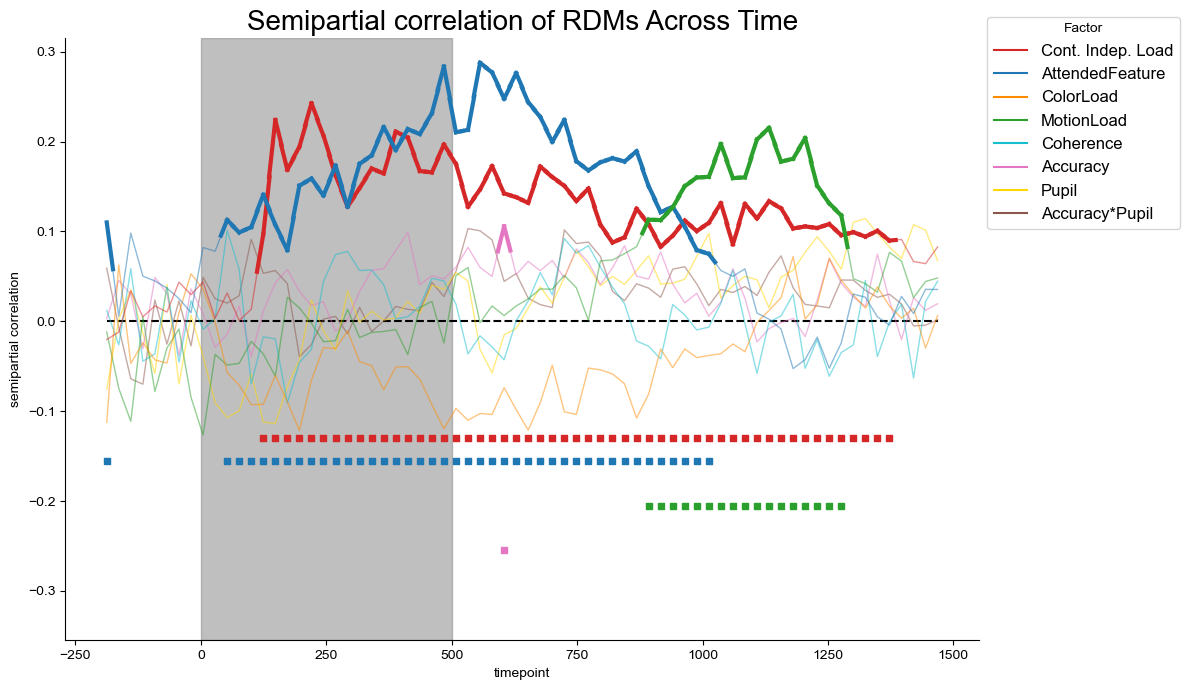

In [251]:
partial_r_df = get_semipartial_correlations(RDM_df, sub_RDMs, other_RDMs={
    'Coherence': coh_rdms,
    'Accuracy': group_avg_acc_RDM,
    'Pupil': pupil_by_time_RDMs,
    'Accuracy*Pupil': interaction_by_time_RDMs
},
skip_subs=bad_eye_subs)
plot_and_test_corrs(partial_r_df, title='all_factors')

# plotting with subject specific values

Cont. Indep. Load Significant timepoints: [ 124.5  148.5  172.5  196.5  220.5  244.5  268.5  292.5  316.5  340.5
  364.5  388.5  412.5  436.5  460.5  484.5  508.5  532.5  556.5  580.5
  604.5  628.5  652.5  676.5  700.5  724.5  748.5  772.5  796.5  820.5
  844.5  868.5  892.5  916.5  940.5  964.5  988.5 1012.5 1036.5 1060.5
 1084.5 1108.5 1132.5 1156.5 1180.5 1204.5 1228.5 1252.5 1300.5 1324.5
 1348.5 1372.5 1396.5 1420.5 1444.5]
AttendedFeature Significant timepoints: [-187.5 -139.5 -115.5  100.5  124.5  196.5  220.5  244.5  268.5  292.5
  316.5  340.5  364.5  388.5  412.5  436.5  460.5  484.5  508.5  532.5
  556.5  580.5  604.5  628.5  652.5  676.5  700.5  724.5  748.5  772.5
  796.5  820.5  844.5  868.5  892.5  916.5  940.5  988.5 1012.5 1084.5]
ColorLoad Significant timepoints: []
MotionLoad Significant timepoints: [ 796.5  820.5  844.5  868.5  892.5  916.5  940.5  964.5  988.5 1012.5
 1036.5 1060.5 1084.5 1108.5 1132.5 1156.5 1180.5 1204.5 1228.5 1252.5
 1276.5 1300.5 1324.5 1372.

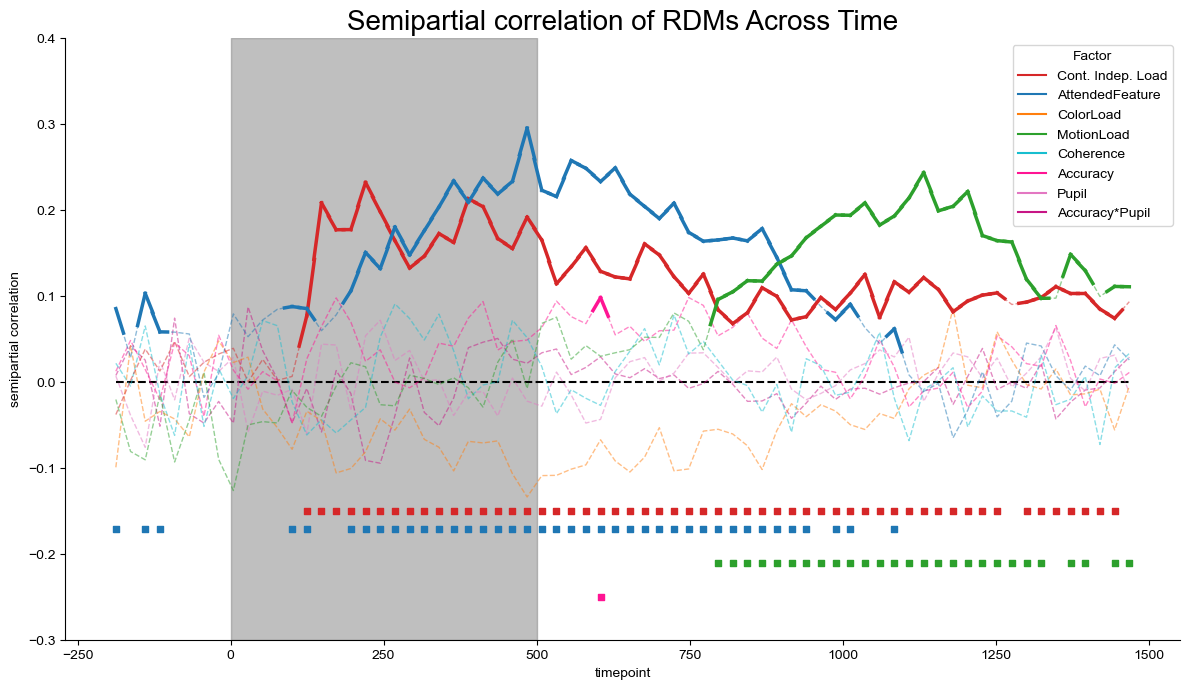

In [203]:
partial_r_df = get_semipartial_correlations(RDM_df, sub_RDMs, other_RDMs={
    'Coherence': coh_rdms,
    'Accuracy': group_avg_acc_RDM,
    'Pupil': pupil_by_time_RDMs_per_sub,
    'Accuracy*Pupil': interaction_by_time_RDMs_per_sub
},
skip_subs = bad_eye_subs)
plot_and_test_corrs(partial_r_df, title='all_factors_by_sub')

# repeat above using coarse accuracy

Cont. Indep. Load Significant timepoints: [ 148.5  172.5  196.5  220.5  244.5  268.5  292.5  316.5  340.5  364.5
  388.5  412.5  436.5  460.5  484.5  508.5  532.5  556.5  580.5  604.5
  628.5  652.5  676.5  700.5  724.5  748.5  772.5  796.5  820.5  844.5
  868.5  892.5  940.5  964.5  988.5 1012.5 1036.5 1060.5 1084.5 1108.5
 1132.5 1156.5 1180.5 1204.5 1228.5 1252.5 1276.5 1300.5 1324.5 1348.5
 1372.5 1396.5 1420.5 1468.5]
AttendedFeature Significant timepoints: [-187.5  -67.5   28.5   76.5  124.5  196.5  244.5  268.5  292.5  316.5
  340.5  364.5  388.5  412.5  436.5  460.5  484.5  508.5  532.5  556.5
  580.5  604.5  628.5  652.5  676.5  700.5  724.5  748.5  772.5  796.5
  820.5  844.5  868.5  892.5  916.5]
ColorLoad Significant timepoints: []
MotionLoad Significant timepoints: []
Coherence Significant timepoints: [676.5 724.5]
Accuracy Significant timepoints: []
Pupil Significant timepoints: []
Accuracy*Pupil Significant timepoints: []


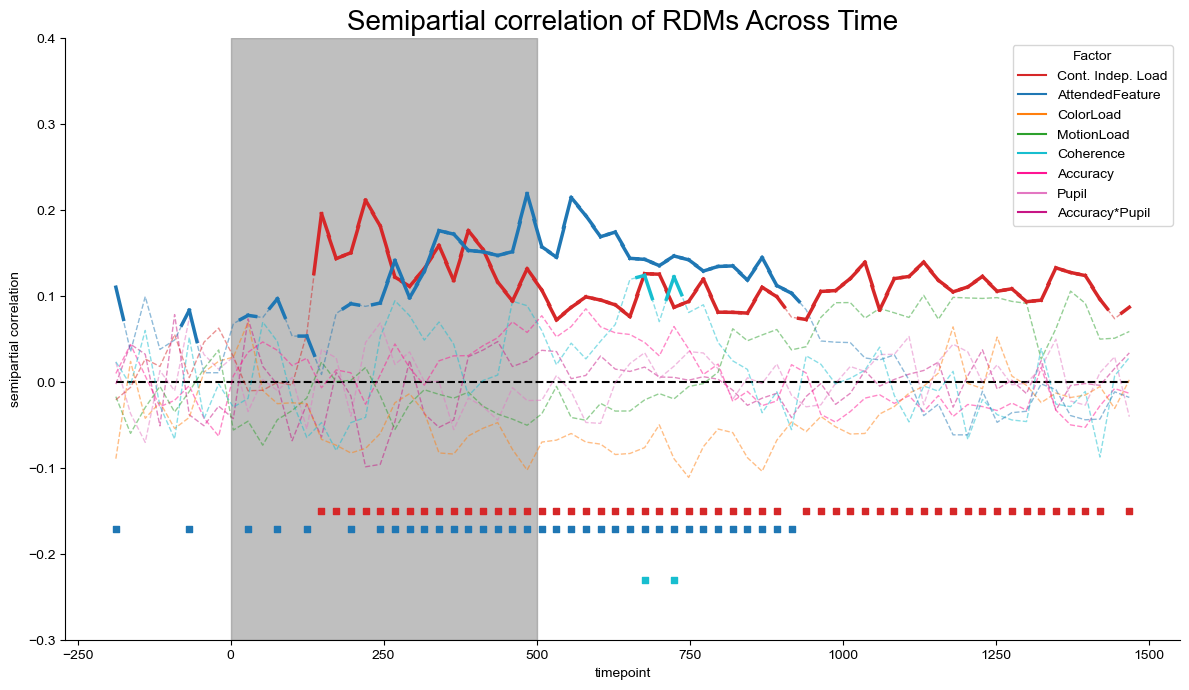

In [204]:
partial_r_df = get_semipartial_correlations(RDM_df, sub_RDMs, other_RDMs={
    'Coherence': coh_rdms,
    'Accuracy': coarse_acc_RDMs,
    'Pupil': pupil_by_time_RDMs_per_sub,
    'Accuracy*Pupil': interaction_by_time_RDMs_per_sub
},
skip_subs = bad_eye_subs)
plot_and_test_corrs(partial_r_df, title='all_factors_coarse_acc')

### Check VIFs and correlation w/ accuracy

In [195]:
def est_vif(desmat):
    '''
    Taken from https://github.com/jmumford/vif_contrasts/blob/main/vif_contrasts.ipynb
    General variance inflation factor estimation.  Calculates VIF for all 
    regressors in the design matrix
    input:
        desmat: design matrix.  Intercept not required.
    output:
      vif_data: Variance inflation factor for each regressor in the design matrix
                generally goal is VIF<5
    '''
    from statsmodels.stats.outliers_influence import variance_inflation_factor
    desmat_with_intercept = desmat.copy()
    desmat_with_intercept['intercept'] = 1
    vif_data = pd.DataFrame()
    vif_data['Factor'] = desmat_with_intercept.columns.drop('intercept')
    vif_data['VIF'] = [variance_inflation_factor(desmat_with_intercept.values, i)
                          for i in range(len(desmat_with_intercept.columns))
                          if desmat_with_intercept.columns[i] != 'intercept']
    return vif_data

In [196]:
def get_VIFs(RDM_df, factors=None, other_RDMs=None, skip_subs=None):
    if factors is None:
        factors = ['Cont. Indep. Load', 'AttendedFeature', 'ColorLoad', 'MotionLoad']

    skip_subs = skip_subs if skip_subs is not None else []

    VIF_df = pd.DataFrame()
    for isub in range(exp.nsub):
        if isub in skip_subs:
            continue

        for t, time in enumerate(timepoints):

            RDM_df = RDM_df.loc[:, factors] 
            if other_RDMs is not None:
                for fac in other_RDMs:
                    curr_RDMs = other_RDMs[fac]
                    if type(curr_RDMs) in [dict, defaultdict]:  # assume there is an RDM per subject
                        sub_RDM = curr_RDMs[isub]
                        if type(sub_RDM) == list:  # assume there is an RDM per timepoint
                            RDM_df[fac] = sub_RDM[t][ridx, cidx]
                        elif sub_RDM.ndim == 3:  # time dimension built into the RDM
                            RDM_df[fac] = sub_RDM[t][ridx, cidx]
                        else:
                            RDM_df[fac] = sub_RDM[ridx, cidx]
                    else:
                        if type(curr_RDMs)==list:  # assume there is an RDM per timepoint, but shared across subjects
                            RDM_df[fac] = curr_RDMs[t][ridx, cidx]
                        elif curr_RDMs.ndim == 3:
                            RDM_df[fac] = curr_RDMs[t][ridx, cidx]
                        else:
                            RDM_df[fac] = curr_RDMs[ridx, cidx]  # just assume there is a single RDM for all timepoints and subjects (e.g., group averaged accuracy)
            ranked_df = RDM_df.rank(axis=0)
            ranked_df['intercept'] = 1
            vif_data= est_vif(ranked_df)
            vif_data['sid'] = isub
            vif_data['timepoint'] = time
            VIF_df = pd.concat([VIF_df, vif_data], axis=0)

    return VIF_df

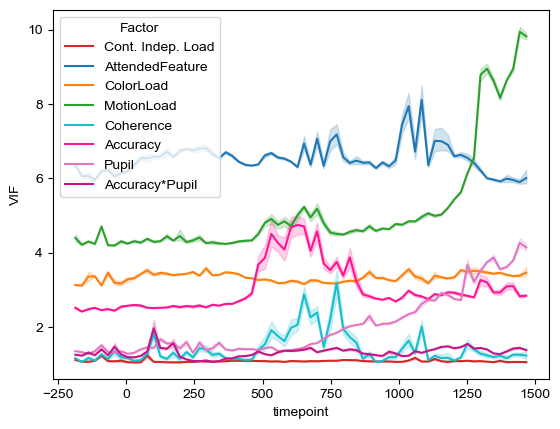

,VIF,sid,timepoint
Factor,,,
Accuracy,3.023318,7.066667,640.5
Accuracy*Pupil,1.323460,7.066667,640.5
AttendedFeature,6.519974,7.066667,640.5
Coherence,1.417979,7.066667,640.5
ColorLoad,3.341039,7.066667,640.5
Cont. Indep. Load,1.084725,7.066667,640.5
MotionLoad,5.148078,7.066667,640.5
Pupil,2.027791,7.066667,640.5


In [201]:
# group_average
VIFs_standard = get_VIFs(RDM_df, other_RDMs={
    'Coherence': coh_rdms,
    'Accuracy': group_avg_acc_RDM,
    'Pupil': pupil_by_time_RDMs,
    'Accuracy*Pupil': interaction_by_time_RDMs
},
skip_subs=bad_eye_subs)
sns.lineplot(x='timepoint', y='VIF', data=VIFs_standard, hue='Factor', palette=color_palette)
plt.show()
plt.close()
VIFs_standard.groupby('Factor').mean()

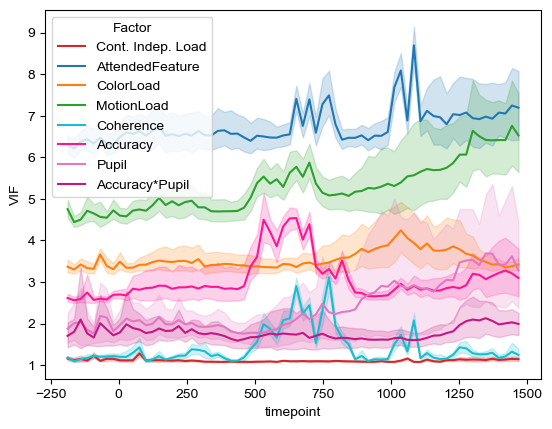

,VIF,sid,timepoint
Factor,,,
Accuracy,3.065036,7.066667,640.5
Accuracy*Pupil,1.779973,7.066667,640.5
AttendedFeature,6.754649,7.066667,640.5
Coherence,1.425440,7.066667,640.5
ColorLoad,3.541388,7.066667,640.5
Cont. Indep. Load,1.110164,7.066667,640.5
MotionLoad,5.288671,7.066667,640.5
Pupil,2.409131,7.066667,640.5


In [200]:
# sub-specific
VIFs_standard = get_VIFs(RDM_df, other_RDMs={
    'Coherence': coh_rdms,
    'Accuracy': group_avg_acc_RDM,
    'Pupil': pupil_by_time_RDMs_per_sub,
    'Accuracy*Pupil': interaction_by_time_RDMs_per_sub
},
skip_subs=bad_eye_subs)
sns.lineplot(x='timepoint', y='VIF', data=VIFs_standard, hue='Factor', palette=color_palette)
plt.show()
plt.close()
VIFs_standard.groupby('Factor').mean()

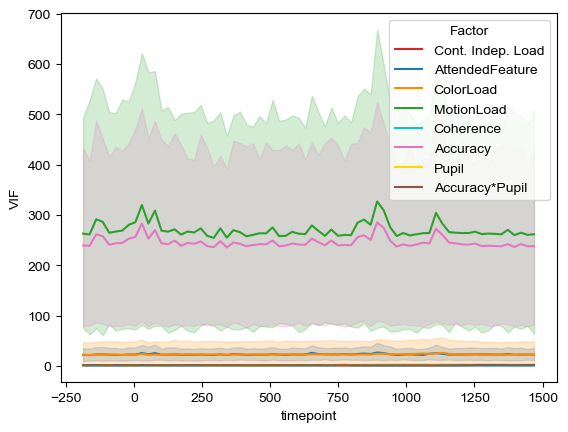

,VIF,sid,timepoint
Factor,,,
Accuracy,246.447658,7.066667,640.5
Accuracy*Pupil,1.760025,7.066667,640.5
AttendedFeature,23.182925,7.066667,640.5
Coherence,1.291774,7.066667,640.5
ColorLoad,23.117949,7.066667,640.5
Cont. Indep. Load,1.855610,7.066667,640.5
MotionLoad,270.709399,7.066667,640.5
Pupil,2.307677,7.066667,640.5


In [260]:
# sub-specific
VIFs_standard = get_VIFs(RDM_df, other_RDMs={
    'Coherence': coh_rdms,
    'Accuracy': coarse_acc_RDMs,
    'Pupil': pupil_by_time_RDMs_per_sub,
    'Accuracy*Pupil': interaction_by_time_RDMs_per_sub
},
skip_subs=bad_eye_subs)
sns.lineplot(x='timepoint', y='VIF', data=VIFs_standard, hue='Factor', palette=color_palette)
plt.show()
plt.close()
VIFs_standard.groupby('Factor').mean()

# correlate motion load timecourse with drop in generalization

In [43]:
from scipy.stats import ttest_1samp
from scipy.stats import pearsonr

In [45]:
interp = eeg_decoder.Interpreter()
interp.load_results('motion_to_color')
cond1_diff = interp.confidence_scores[..., 1] - interp.confidence_scores[..., 0]  # SS2_col - SS1_col
cond1_scores = np.mean(cond1_diff, axis=2)

cond2_diff = interp.confidence_scores[..., 3] - interp.confidence_scores[..., 2]  # SS2_mot - SS1_mot
cond2_scores = np.mean(cond2_diff, axis=2)
generalization_cost = cond2_scores - cond1_scores

Cont. Indep. Load Significant timepoints: [ 124.5  148.5  172.5  196.5  220.5  244.5  268.5  292.5  316.5  340.5
  364.5  388.5  412.5  436.5  460.5  484.5  508.5  532.5  556.5  580.5
  604.5  628.5  652.5  676.5  700.5  724.5  748.5  772.5  796.5  820.5
  844.5  868.5  892.5  916.5  940.5  964.5  988.5 1012.5 1036.5 1060.5
 1084.5 1108.5 1132.5 1156.5 1180.5 1204.5 1228.5 1252.5 1276.5 1300.5
 1324.5 1348.5 1372.5]
AttendedFeature Significant timepoints: [-187.5   52.5   76.5  100.5  124.5  148.5  172.5  196.5  220.5  244.5
  268.5  292.5  316.5  340.5  364.5  388.5  412.5  436.5  460.5  484.5
  508.5  532.5  556.5  580.5  604.5  628.5  652.5  676.5  700.5  724.5
  748.5  772.5  796.5  820.5  844.5  868.5  892.5  916.5  940.5  964.5
  988.5 1012.5]
ColorLoad Significant timepoints: []
MotionLoad Significant timepoints: [ 892.5  916.5  940.5  964.5  988.5 1012.5 1036.5 1060.5 1084.5 1108.5
 1132.5 1156.5 1180.5 1204.5 1228.5 1252.5 1276.5]
Coherence Significant timepoints: []
Accuracy 

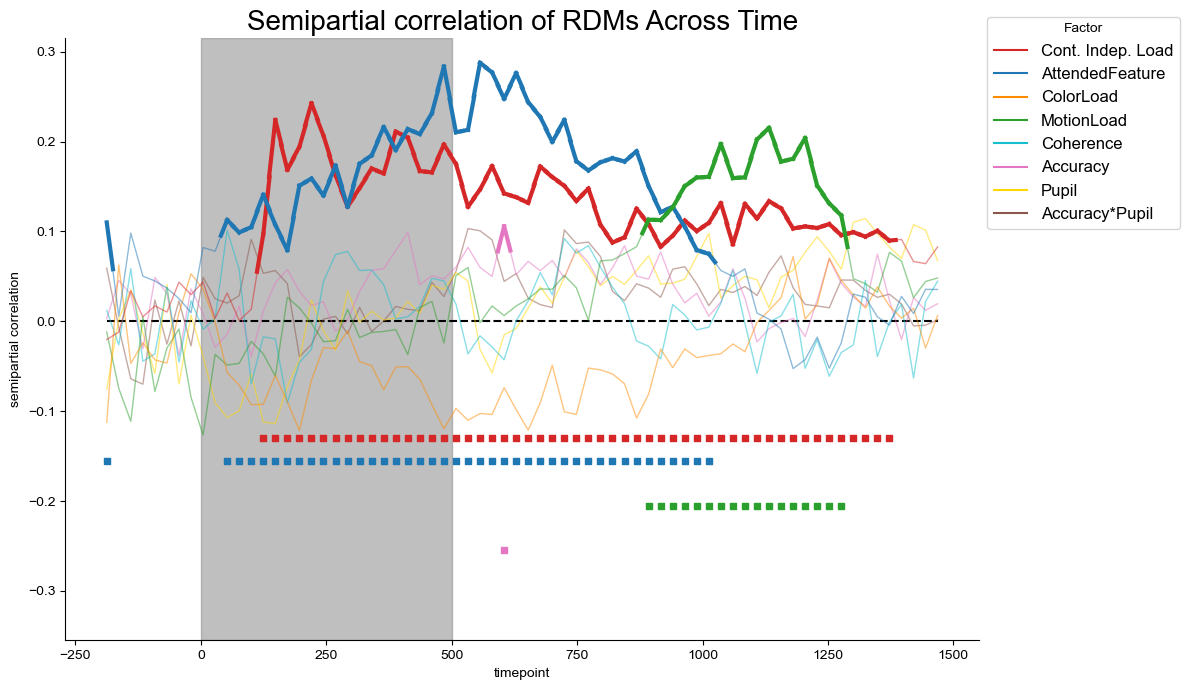

In [252]:
partial_r_df = get_semipartial_correlations(RDM_df, sub_RDMs, other_RDMs={
    'Coherence': coh_rdms,
    'Accuracy': group_avg_acc_RDM,
    'Pupil': pupil_by_time_RDMs,
    'Accuracy*Pupil': interaction_by_time_RDMs
},
skip_subs=bad_eye_subs)
plot_and_test_corrs(partial_r_df, title='all_factors')

In [253]:
interp = eeg_decoder.Interpreter()
interp.load_results('motion_to_color')
cond1_diff = interp.confidence_scores[..., 1] - interp.confidence_scores[..., 0]  # SS2_col - SS1_col
cond1_scores = np.mean(cond1_diff, axis=2)

cond2_diff = interp.confidence_scores[..., 3] - interp.confidence_scores[..., 2]  # SS2_mot - SS1_mot
cond2_scores = np.mean(cond2_diff, axis=2)
generalization_cost = cond2_scores - cond1_scores

<Axes: ylabel='Count'>

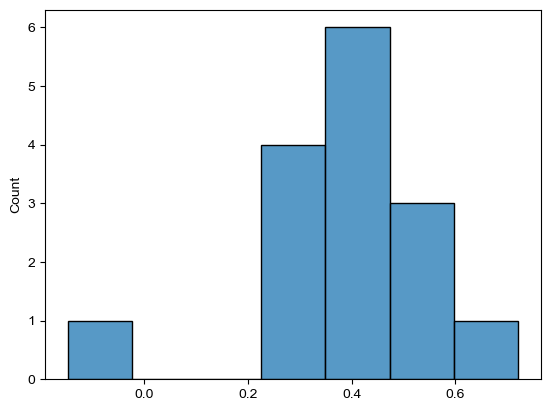

In [255]:
motion_corrs = []
for isub in range(exp.nsub):
    if isub in bad_eye_subs:
        pass
    else:
        sub_motion_load = partial_r_df.query('factor=="MotionLoad"').query(f'sid=={isub}')['semipartial correlation'].values
        motion_corrs.append(np.corrcoef(sub_motion_load, generalization_cost[isub, :])[0, 1])
sns.histplot(motion_corrs)

In [259]:
len(motion_corrs)

15

In [256]:
wilcoxon(motion_corrs)

WilcoxonResult(statistic=1.0, pvalue=0.0001220703125)

In [257]:
# fisher's z transform
z = np.arctanh(motion_corrs)
ttest_1samp(z, 0)

TtestResult(statistic=7.083057987564869, pvalue=5.4808939900415985e-06, df=14)

In [258]:
print(np.mean(z), np.tanh(np.mean(z)))

0.41195896132483656 0.3901347457199752
